In [1]:
%%bash

pip install gymnasium==0.29.1
pip install gymnasium[atari]
pip install gymnasium[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=12430c466261f1e8ae75844c4ffdfa6767d66ff3659420c77e9e4ef6ca73bfab
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [2]:
import gymnasium as gym; print(f'Gymnasium v{gym.__version__}')

Gymnasium v0.29.1


In [3]:
%%bash

pip install "stable-baselines3[extra]>=2.0.0a4"
pip install sb3-contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.7/183.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 3.8 MB/s eta 0:00:00


In [4]:
!git clone https://github.com/danijar/crafter.git

Cloning into 'crafter'...
remote: Enumerating objects: 996, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 996 (delta 218), reused 197 (delta 197), pack-reused 752 (from 1)
Receiving objects: 100% (996/996), 44.54 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (624/624), done.


In [7]:
%%bash

mkdir crafter_runs
mkdir models_cmp
mkdir logs

In [8]:
%%bash

cd crafter
pip install .Y

Processing /content/crafter
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for crafter: filename=crafter-1.8.3-py3-none-any.whl size=144000 sha256=4226b1a14d321df1a8c73ab0413c0c0c62ccaf3feca040df0c73293c7c55374b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tq4ls22x/wheels/ab/1b/90/4b5f6b8d2fa81939f088bc9092b431fdd24899de708898c873
Successfully built crafter
  Attempting uninstall: crafter
    Found existing installation: crafter 1.8.3
    Uninstalling crafter-1.8.3:
      Successfully uninstalled crafter-1.8.3


In [10]:
!pip uninstall gym

In [19]:
from gymnasium import spaces
from gymnasium.spaces import Dict, Box, MultiDiscrete
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecEnv, SubprocVecEnv
from stable_baselines3.common.vec_env import VecEnv, SubprocVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor, NatureCNN, create_mlp
import torch as th
from torch import nn
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
import gym as legacy_gym  # For legacy gym
from gymnasium.spaces import Discrete, Box, MultiDiscrete
import crafter
from gymnasium.envs.registration import register
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

In [47]:
class NonNotebookEnvWrapper(gym.Env):
    def __init__(self, venv):
        self.venv = venv

        self.observation_space = spaces.Box(low=0, high=255, shape=venv.observation_space.shape, dtype=venv.observation_space.dtype),  # Original Observation Space
        self.action_space = spaces.Discrete(venv.action_space.n)
        print(f"Observation Space: {self.observation_space}")
        print(f"Action Space: {self.action_space}")

    def reset(self, seed=None, options=None):
        # Pass the seed and options to the underlying environment's reset method
        observations, info = self.venv.reset()
        return observations, info

    def step(self, action):
        venv_obs, reward, truncated, terminated, info = self.venv.step(action)
        return venv_obs, reward, truncated, terminated, info

    def seed(self, seed):
        # Seed the underlying environment
        return self.venv.seed(seed)

    def env_is_wrapped(self, wrapper_class, indices=None):
        return self.venv.env_is_wrapped(wrapper_class, indices)

    def get_attr(self, attr_name, indices=None):
        return self.venv.get_attr(attr_name, indices)

    def set_attr(self, attr_name, value, indices=None):
        return self.venv.set_attr(attr_name, value, indices)

    def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
        return self.venv.env_method(method_name, *method_args, indices=indices, **method_kwargs)

    def step_async(self, actions):
        self.venv.step_async(actions)

    def step_wait(self):
        return self.venv.step_wait()

    def render(self):
        return self.venv.render()

    def close(self):
        return self.venv.close()

    def __getattr__(self, attr):
        return getattr(self.venv, attr)

    def __str__(self):
        return str(self.venv)

    def __repr__(self):
        return repr(self.venv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
class NotebookEnvWrapper(gym.Env):
    def __init__(self, venv, notebook_size=8):
        self.venv = venv
        self.notebook_size = notebook_size
        self.notebook = np.ones(self.notebook_size, dtype=np.int32)

        self.observation_space = spaces.Dict({
            "env": spaces.Box(low=0, high=255, shape=venv.observation_space.shape, dtype=venv.observation_space.dtype),  # Original Observation Space
            "notebook": spaces.MultiDiscrete([2] * self.notebook_size)
        })
        self.action_space = spaces.MultiDiscrete([venv.action_space.n, self.notebook_size, 2])
        print(f"Observation Space: {self.observation_space}")
        print(f"Action Space: {self.action_space}")

    def reset(self, seed=None, options=None):
        # Pass the seed and options to the underlying environment's reset method
        observations, info = self.venv.reset()

        # Reset the notebook to its initial state
        self.notebook = np.ones(self.notebook_size, dtype=np.int32)

        # Return the combined observation
        reset_observation = {
            "env": observations,  # Original Observation Space
            "notebook": self.notebook
        }
        return reset_observation, info

    def step(self, action):
        venv_action, notebook_index, notebook_value = action
        venv_obs, reward, truncated, terminated, info = self.venv.step(venv_action)
        self.notebook[notebook_index] = notebook_value
        combined_observation = {
            "env": venv_obs,  # Observations from the original environment
            "notebook": self.notebook,  # Current notebook state
        }
        return combined_observation, reward, truncated, terminated, info

    def seed(self, seed):
        # Seed the underlying environment
        return self.venv.seed(seed)

    def env_is_wrapped(self, wrapper_class, indices=None):
        return self.venv.env_is_wrapped(wrapper_class, indices)

    def get_attr(self, attr_name, indices=None):
        return self.venv.get_attr(attr_name, indices)

    def set_attr(self, attr_name, value, indices=None):
        return self.venv.set_attr(attr_name, value, indices)

    def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
        return self.venv.env_method(method_name, *method_args, indices=indices, **method_kwargs)

    def step_async(self, actions):
        self.venv.step_async(actions)

    def step_wait(self):
        return self.venv.step_wait()

    def render(self):
        return self.venv.render()

    def close(self):
        return self.venv.close()

    def __getattr__(self, attr):
        return getattr(self.venv, attr)

    def __str__(self):
        return str(self.venv)

    def __repr__(self):
        return repr(self.venv)

In [13]:
class GymToGymnasiumWrapper(gym.Env):
    def __init__(self, env):
        self.env = env

        # Handle action spaces
        if isinstance(self.env.action_space, (Discrete, legacy_gym.spaces.Discrete)):
            # Unified handling of Discrete action spaces
            self.action_space = Discrete(self.env.action_space.n)
        elif isinstance(self.env.action_space, (MultiDiscrete, legacy_gym.spaces.MultiDiscrete)):
            self.action_space = MultiDiscrete(self.env.action_space.nvec)
        elif isinstance(self.env.action_space, (Box, legacy_gym.spaces.Box)):
            self.action_space = Box(
                low=self.env.action_space.low,
                high=self.env.action_space.high,
                dtype=self.env.action_space.dtype,
            )
        else:
            raise ValueError(f"Unsupported action space type: {type(self.env.action_space)}")

        # Handle observation spaces
        if isinstance(self.env.observation_space, (Box, legacy_gym.spaces.Box)):
            self.observation_space = Box(
                low=self.env.observation_space.low,
                high=self.env.observation_space.high,
                dtype=self.env.observation_space.dtype,
            )
        elif isinstance(self.env.observation_space, (MultiDiscrete, legacy_gym.spaces.MultiDiscrete)):
            self.observation_space = MultiDiscrete(self.env.observation_space.nvec)
        else:
            raise ValueError(f"Unsupported observation space type: {type(self.env.observation_space)}")

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        return obs, {}  # Gymnasium expects a tuple (observation, info)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return obs, reward, done, False, info  # Gymnasium expects (obs, reward, done, truncated, info)

    def render(self, mode="human"):
        return self.env.render(mode=mode)

    def close(self):
        self.env.close()



In [48]:
# Register the environment manually
register(
    id="CrafterReward-v1",
    entry_point="crafter.env:Env",  # Specify the correct entry point
    kwargs={"reward": True},       # Enable rewards for the environment
    max_episode_steps=1000,        # Set the maximum number of steps per episode
)

# Create the Crafter environment
crafter_env = crafter.env.Env(reward=True)
print(type(crafter_env.action_space))
print(crafter_env.action_space)
# Wrap it with the Crafter recorder
crafter_env = crafter.Recorder(
    crafter_env,
    directory='crafter_runs',
    save_stats=True,
    save_video=True
)
# Wrap the environment to make it compatible with Gymnasium
env = GymToGymnasiumWrapper(crafter_env)
# crafter_env = gym.make("GymV26Environment-v0", env_id=gym.make("CrafterReward-v1"))
notebook_env = NotebookEnvWrapper(env)
non_notebook_env = NonNotebookEnvWrapper(env)
print(type(notebook_env))
print(notebook_env.observation_space)
print(notebook_env.action_space)


# obs, info = notebook_env.reset()
# done = False
# while not done:
#     action = notebook_env.action_space.sample()
#     print(f"Action: {action}")
#     obs, reward, truncated, terminated, info = notebook_env.step(action)
#     done = truncated or terminated
#     print(f"Reward: {reward}, Done: {done}")


<class 'gym.spaces.discrete.Discrete'>
Discrete(17)
Observation Space: Dict('env': Box(0, 255, (64, 64, 3), uint8), 'notebook': MultiDiscrete([2 2 2 2 2 2 2 2]))
Action Space: MultiDiscrete([17  8  2])
Observation Space: (Box(0, 255, (64, 64, 3), uint8),)
Action Space: Discrete(17)
<class '__main__.NotebookEnvWrapper'>
Dict('env': Box(0, 255, (64, 64, 3), uint8), 'notebook': MultiDiscrete([2 2 2 2 2 2 2 2]))
MultiDiscrete([17  8  2])


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CrafterReward-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [30]:
class FlattenNotebookObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Calculate the total size of the flattened observation space
        env_obs_size = np.prod(env.observation_space['env'].shape)
        notebook_obs_size = np.prod(env.observation_space['notebook'].nvec.shape)
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(env_obs_size + notebook_obs_size,),
            dtype=np.uint8
        )

    def observation(self, observation):
        # Flatten and concatenate the observations
        env_obs = observation['env'].flatten()
        notebook_obs = observation['notebook'].flatten()
        return np.concatenate([env_obs, notebook_obs])


In [33]:
class FlattenObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Calculate the total size of the flattened observation space
        env_obs_size = np.prod(env.observation_space[0].shape)
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(env_obs_size,),
            dtype=np.uint8
        )

    def observation(self, observation):
        # Flatten the observations
        env_obs = observation.flatten()
        return env_obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Function to create the environment
def make_notebook_env():
    flat_env = FlattenNotebookObservationWrapper(notebook_env)  # Apply the wrapper to flatten the observation space
    return flat_env

def make_non_notebook_env():
    flat_env = FlattenObservationWrapper(non_notebook_env)  # Apply the wrapper to flatten the observation space
    return flat_env

# Create a vectorized environment with the custom wrapper
notebook_vec_env = DummyVecEnv([make_notebook_env])  # Vectorize the environment
vec_env = DummyVecEnv([make_non_notebook_env])  # Vectorize the environment
print(f"Type of notebook_vec_env: {type(notebook_vec_env)} and its obs space {type(notebook_vec_env.observation_space)} where the obs space is {notebook_vec_env.observation_space}")
print(f"Type of vec_env: {type(vec_env)} and its obs space {type(vec_env.observation_space)} where the obs space is {vec_env.observation_space}")


#vec_env = VecTransposeImage(vec_env)  # Ensure channel-first image format (if needed)

# # Define and train the PPO model
# model = RecurrentPPO(
#     policy="MlpLstmPolicy",  # Use MLP policy for flat observation space
#     env=vec_env,
#     verbose=1,
#     n_steps=256,
#     batch_size=64,
#     gamma=0.99,
#     gae_lambda=0.95,
#     learning_rate=3e-4,
#     use_sde=False,
#     normalize_advantage=True,
# )

# # Train the model
# model.learn(total_timesteps=200000)


Type of notebook_vec_env: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'> and its obs space <class 'gymnasium.spaces.box.Box'> where the obs space is Box(0, 255, (12296,), uint8)
Type of vec_env: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'> and its obs space <class 'gymnasium.spaces.box.Box'> where the obs space is Box(0, 255, (12288,), uint8)


In [61]:
n = 1
total_timesteps = 10000
eval_interval = 500  # Evaluate every 500 timesteps

# Train n PO models
for i in range(n):
    model = RecurrentPPO(
        policy="MlpLstmPolicy",  # Use MLP policy for flat observation space
        env=vec_env,
        verbose=1,
        n_steps=256,
        batch_size=64,
        gamma=0.99,
        gae_lambda=0.95,
        learning_rate=3e-4,
        use_sde=False,
        normalize_advantage=True,
    )
    logger = configure("logs/rppo_crafter_po_" + str(i), ["csv", "tensorboard"])
    model.set_logger(logger)

    # Start training the model -> Need custom training loop as eval_metrics are
    # not logged by default by the RecurrentPPO model
    for step in range(0, total_timesteps, eval_interval):
        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)

        # Periodically evaluate the policy after each `eval_interval`
        if step % eval_interval == 0:
            print(f"Evaluating the model at timestep {step}...")
            # Perform evaluation (using n_eval_episodes=5 for the evaluation)
            rewards, lengths = evaluate_policy(model, vec_env, n_eval_episodes=5, return_episode_rewards=True)

            # Log evaluation metrics manually
            mean_reward = np.mean(rewards)
            mean_length = np.mean(lengths)
            logger.record("rollout/ep_rew_mean", mean_reward)
            logger.record("rollout/ep_len_mean", mean_length)
            logger.dump(step)

    model.save(f"models_cmp/rppo_crafter_po_{i}")
    #print(f"PO Model {i} trained")

# Train n notebook models
for i in range(n):
    model = RecurrentPPO(
        policy="MlpLstmPolicy",  # Use MLP policy for flat observation space
        env=notebook_vec_env,
        verbose=1,
        n_steps=256,
        batch_size=64,
        gamma=0.99,
        gae_lambda=0.95,
        learning_rate=3e-4,
        use_sde=False,
        normalize_advantage=True,
    )
    logger = configure("logs/rppo_crafter_notebook_" + str(i), ["csv", "tensorboard"])
    model.set_logger(logger)

    # Start training the model -> Need custom training loop as eval_metrics are
    # not logged by default by the RecurrentPPO model
    for step in range(0, total_timesteps, eval_interval):
        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)

        # Periodically evaluate the policy after each `eval_interval`
        if step % eval_interval == 0:
            print(f"Evaluating the model at timestep {step}...")
            # Perform evaluation (using n_eval_episodes=5 for the evaluation)
            rewards, lengths = evaluate_policy(model, notebook_vec_env, n_eval_episodes=5, return_episode_rewards=True)

            # Log evaluation metrics manually
            mean_reward = np.mean(rewards)
            mean_length = np.mean(lengths)
            logger.record("rollout/ep_rew_mean", mean_reward)
            logger.record("rollout/ep_len_mean", mean_length)
            logger.dump(step)
    model.save(f"models_cmp/rppo_crafter_notebook_{i}")
    #print(f"Notebook Model {i} trained")

Using cuda device
Evaluating the model at timestep 0...
Evaluating the model at timestep 500...
Evaluating the model at timestep 1000...
Evaluating the model at timestep 1500...
Evaluating the model at timestep 2000...
Evaluating the model at timestep 2500...
Evaluating the model at timestep 3000...
Evaluating the model at timestep 3500...
Evaluating the model at timestep 4000...
Evaluating the model at timestep 4500...
Evaluating the model at timestep 5000...
Evaluating the model at timestep 5500...
Evaluating the model at timestep 6000...
Evaluating the model at timestep 6500...
Evaluating the model at timestep 7000...
Evaluating the model at timestep 7500...
Evaluating the model at timestep 8000...
Evaluating the model at timestep 8500...
Evaluating the model at timestep 9000...
Evaluating the model at timestep 9500...


In [62]:
n = 1

mean_episode_lengths_po = []
std_episode_lengths_po = []
mean_rewards_po = []
std_rewards_po = []

for i in range(n):
    model = RecurrentPPO.load(f"models_cmp/rppo_crafter_po_{i}")
    rewards, lengths = evaluate_policy(model, vec_env, n_eval_episodes=1, return_episode_rewards=True)

    mean_episode_length = np.mean(lengths)
    std_episode_length = np.std(lengths)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    mean_episode_lengths_po.append(mean_episode_length)
    std_episode_lengths_po.append(std_episode_length)
    mean_rewards_po.append(mean_reward)
    std_rewards_po.append(std_reward)
    print(f"PO Model {i}: {mean_reward:.2f} +/- {std_reward:.2f}, mean episode length: {mean_episode_length:.2f} +/- {std_episode_length:.2f}")

PO Model 0: 0.10 +/- 0.00, mean episode length: 171.00 +/- 0.00


In [63]:
n = 1

mean_episode_lengths_notebook = []
std_episode_lengths_notebook = []
mean_rewards_notebook = []
std_rewards_notebook = []

for i in range(n):
    model = RecurrentPPO.load(f"models_cmp/rppo_crafter_notebook_{i}")
    rewards, lengths = evaluate_policy(model, notebook_vec_env, n_eval_episodes=1, return_episode_rewards=True)

    mean_episode_length = np.mean(lengths)
    std_episode_length = np.std(lengths)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    mean_episode_lengths_notebook.append(mean_episode_length)
    std_episode_lengths_notebook.append(std_episode_length)
    mean_rewards_notebook.append(mean_reward)
    std_rewards_notebook.append(std_reward)
    print(f"Notebook Model {i}: {mean_reward:.2f} +/- {std_reward:.2f}, mean episode length: {mean_episode_length:.2f} +/- {std_episode_length:.2f}")

Notebook Model 0: -0.90 +/- 0.00, mean episode length: 274.00 +/- 0.00


In [64]:
print("PO models")
print(f"Mean episode length: {np.mean(mean_episode_lengths_po):.2f} +/- {np.mean(std_episode_lengths_po):.2f}")
print(f"Mean reward: {np.mean(mean_rewards_po):.2f} +/- {np.mean(std_rewards_po):.2f}")
print("Notebook models")
print(f"Mean episode length: {np.mean(mean_episode_lengths_notebook):.2f} +/- {np.mean(std_episode_lengths_notebook):.2f}")
print(f"Mean reward: {np.mean(mean_rewards_notebook):.2f} +/- {np.mean(std_rewards_notebook):.2f}")

PO models
Mean episode length: 171.00 +/- 0.00
Mean reward: 0.10 +/- 0.00
Notebook models
Mean episode length: 274.00 +/- 0.00
Mean reward: -0.90 +/- 0.00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Notebook Models Loss')

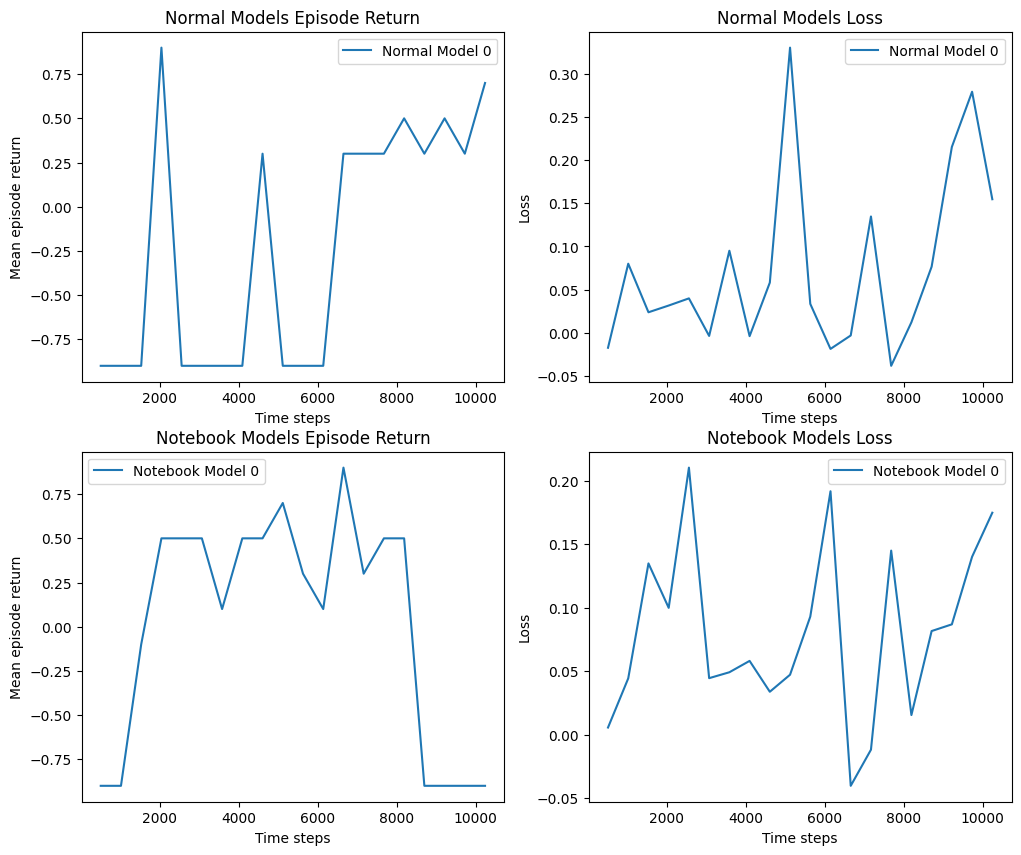

In [75]:
# 2x2 grid of plots
plt.figure(figsize=(12, 10))

plt.subplot(221)
for i in range(n):
    po_df = pd.read_csv(f"logs/rppo_crafter_po_{i}/progress.csv")
    #print(f"the dataframe columns are {po_df.columns}")
    df_cleaned = po_df.dropna(subset=["time/total_timesteps"])
    df_odd_indices = df_cleaned.iloc[1::2]
    time = df_odd_indices["time/total_timesteps"]
    #print(f"the time column is {time}")
    df_cleaned = po_df.dropna(subset=["rollout/ep_rew_mean"])
    reward = df_cleaned["rollout/ep_rew_mean"]
    #print(f"the reward column is {reward}")
    plt.plot(time, reward, label=f"Normal Model {i}")

plt.xlabel("Time steps")
plt.ylabel("Mean episode return")
plt.legend()
plt.title("Normal Models Episode Return")

plt.subplot(222)
for i in range(n):
    po_df = pd.read_csv(f"logs/rppo_crafter_po_{i}/progress.csv")
    df_cleaned = po_df.dropna(subset=["time/total_timesteps"])
    df_odd_indices = df_cleaned.iloc[1::2]
    time = df_odd_indices["time/total_timesteps"]
    #print(f"the time column is {time}")
    df_cleaned = po_df.dropna(subset=["train/loss"])
    df_odd_indices = df_cleaned.iloc[0::2]
    loss = df_odd_indices["train/loss"]
    #print(f"the loss column is {loss}")
    plt.plot(time, loss, label=f"Normal Model {i}")

plt.xlabel("Time steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Normal Models Loss")

plt.subplot(223)
for i in range(n):
    notebook_df = pd.read_csv(f"logs/rppo_crafter_notebook_{i}/progress.csv")
    #print(f"the dataframe columns are {po_df.columns}")
    df_cleaned = notebook_df.dropna(subset=["time/total_timesteps"])
    df_odd_indices = df_cleaned.iloc[1::2]
    time = df_odd_indices["time/total_timesteps"]
    #print(f"the time column is {time}")
    df_cleaned = notebook_df.dropna(subset=["rollout/ep_rew_mean"])
    reward = df_cleaned["rollout/ep_rew_mean"]
    #print(f"the reward column is {reward}")
    plt.plot(time, reward, label=f"Notebook Model {i}")

plt.xlabel("Time steps")
plt.ylabel("Mean episode return")
plt.legend()
plt.title("Notebook Models Episode Return")

plt.subplot(224)
for i in range(n):
    notebook_df = pd.read_csv(f"logs/rppo_crafter_notebook_{i}/progress.csv")
    df_cleaned = notebook_df.dropna(subset=["time/total_timesteps"])
    df_odd_indices = df_cleaned.iloc[1::2]
    time = df_odd_indices["time/total_timesteps"]
    #print(f"the time column is {time}")
    df_cleaned = notebook_df.dropna(subset=["train/loss"])
    df_odd_indices = df_cleaned.iloc[0::2]
    loss = df_odd_indices["train/loss"]
    #print(f"the loss column is {loss}")
    plt.plot(time, loss, label=f"Notebook Model {i}")

plt.xlabel("Time steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Notebook Models Loss")